# Final Project Submission

Please fill out:
* Student name: Akshay Ghalasi
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Setup and import data


In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
import warnings
import collections
import operator
warnings.filterwarnings('ignore')
%matplotlib inline
%run "Auxillary.ipynb"

In [124]:
df = pd.read_csv('kc_house_data.csv')
#understanding size of data
print(df.shape)
df.head(5)

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


##  Data prepreprocessing

#### We will inspect each column one by one and decide whether to keep it or not or how to modify it. First we will drop id axis and convert the date to something useful. We will also convert all entries to numeric NaNs

In [125]:
### id seems like a random assignment. we will drop it
df.drop('id',axis=1,inplace=True)

### date needs to be parsed in year, month and day. We dont expect day to carry lot of information but we will keep it for now
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df.drop('date',axis=1,inplace=True)


### Not all non numerical enries are stored as nans. So I am converting all non numerical entries to nan
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

df = df[df.applymap(isnumber)]

df.shape

(21597, 22)

#### Now we will get rid of all the nan's. We deal with each feature slightly differently

In [126]:
#Print all the NaNs
(df.isna().sum())[df.isna().sum()>0]

waterfront       2376
view               63
sqft_basement     454
yr_renovated     3842
dtype: int64

In [127]:
### Waterfront has 10% nan's Only 0.1% of homes have a waterfront. We will replace nan's with zeros
df['waterfront'] = df['waterfront'].fillna(0)

### view is a little puzzling as to what it means but we will replace the nans  with the median i.e. 0
df['view'] = df['view'].fillna(df['view'].median())

### sqft basement has nans which we replace with the median i.e. 0. Its also stored as strings for some reason, convert it to float
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['sqft_basement'] = df['sqft_basement'].fillna(df['sqft_basement'].median())

### if yr_renovated is 0 or nan replace it with year built # first I will convert all 0's to nan's and then replace them
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: None if x==0 else x)
df['yr_renovated'].fillna(df['yr_built'],inplace=True)


#### We will visuaally inspect box-whisker plots and get rid of outliers using relevant features

In [128]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'day'],
      dtype='object')

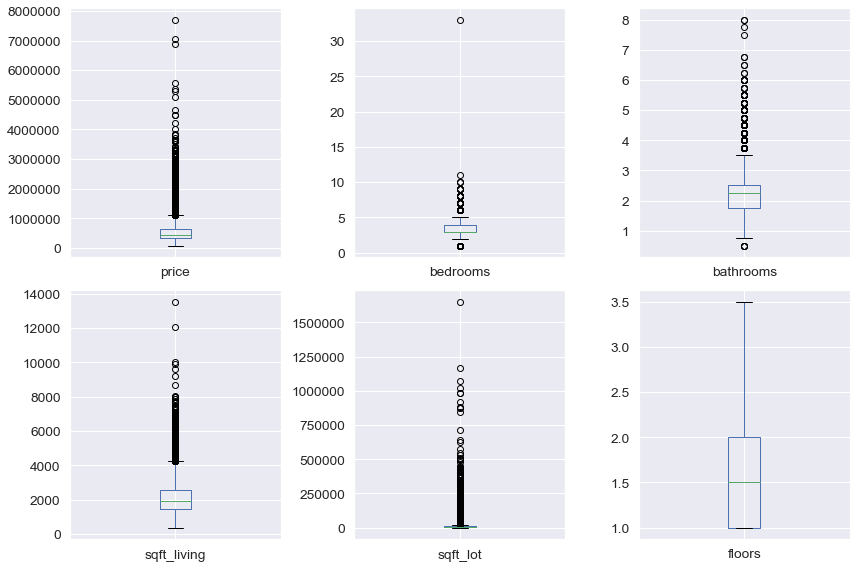

In [132]:
box_plot_col = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']
fig = plt.figure(figsize=(12,8))

for i,col in enumerate(box_plot_col):
    plt.subplot(2,3,i+1);
    df.boxplot(col);
    plt.tight_layout()
plt.savefig('boxplot-outliers.png')

In [164]:
###Clear break in prices above 6,000,000
df = df[df.price < 6000000]

### There is a bedroom with 33 rooms so with incredibly low price so we are going to remove that as an anomaly
df = df[df.bedrooms < 12]

### Clear breaak in bathrooms above 7
df = df[df.bathrooms < 7]

### Clear breaak in sqft living above 10,000
df = df[df.sqft_living < 10000]

### Clear breaak in sqft lot above 750,000
df = df[df.sqft_living < 750000]

### We lost 6 data points which is a trivial amount. We can in the future be even more aggresive with pruning our data

#### Create more features. A better job can be  definitely be done here.

In [165]:
### Coverting it to categorical
df['has_bsmt'] = df['sqft_basement'].apply(lambda x: 1 if x>0.0 else 0)
df['has_2nd_floor'] = df['floors'].apply(lambda x: 1 if x>1.0 else 0)
df['new'] = (df['year']-df['yr_built'] < 30).astype(float)
df['new_renovated'] = (df['year']-df['yr_renovated'] < 20).astype(float)


# We will ask 3 questions in this notebook
## Q1 How well can we predict the price of the house using linear models?
## Q2 Can we make recommendations to the seller of the house regarding when to sell it?
## Q3 Can we  the give the  buyer of the house a range for his needs?

## Q1 How well can we predict the price of the house using linear models?
### Setting a benchmark

#### It is important to set a benchmark of the predictions we make to know if and why we are improving. I will use two benchmark models to predict the price of the house and see how it improves

## Benchmark 1. Linear model based on existing features without any preprocessing

Index(['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15',
       'bathrooms', 'bedrooms', 'floors', 'yr_renovated', 'sqft_lot',
       'sqft_lot15', 'yr_built', 'condition'],
      dtype='object')
The rmse error in log predictions is 0.376


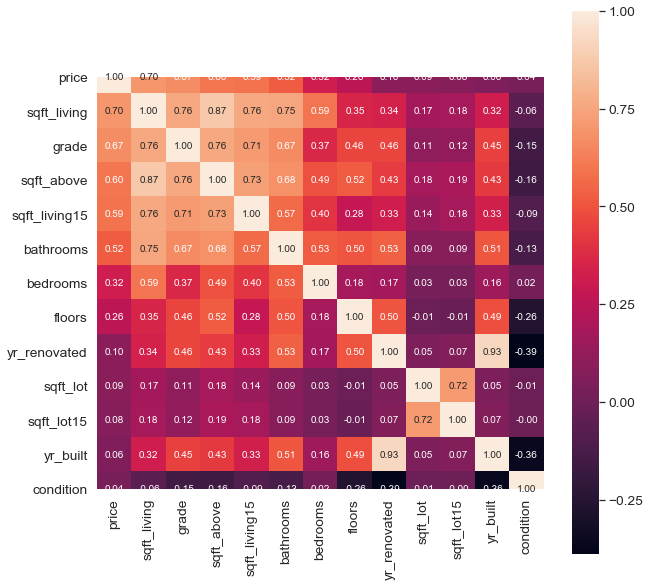

In [95]:
## Here I will create a list of features that have not been preprocessed and make a linear fit.
## First I chose features such that I expect them to have a linear relationship with the target
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15']
ben_1_df = df[lin_feats]

## Lets get a corrmat to figure out what the most important variables are
print(plot_corr(ben_1_df))

## Here I will create a list of features that have not been preprocessed and make a linear fit.
## First I chose features such that I expect them to have a linear relationship with the target
y = ben_1_df['price']
X = ben_1_df.drop('price',axis=1)

## Making a linear fit. First do a train-test split, then fit on train using sklearn linear model and testing predictions on test

# Making a train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


# Doing Ridge regression
ridge = RidgeCV(alphas=np.logspace(0,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
#print(alpha)
#Calculate rmse
testpred[testpred < 0] = np.mean(y_train)
benchmark_1 = [(np.abs(((np.log1p(testpred)-np.log1p(y_test))/np.log1p(y_test)))).mean(),((np.log1p(testpred)-np.log1p(y_test))/np.log1p(y_test)).std(),
               np.sqrt(((np.log1p(testpred)-np.log1p(y_test))**2).sum()/len(y_test))]
print('The rmse error in log predictions is',round(benchmark_1[2],3))


#### As can be seen in plot below, this benchmark is horrible

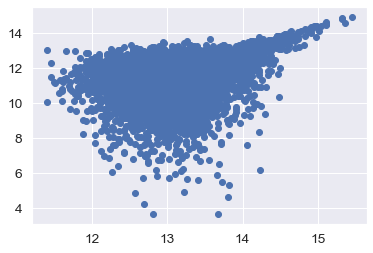

In [96]:
plt.plot(np.log1p(y_test),np.log1p(np.abs(testpred-y_test)),'bo');

## Benchmark 2. Groupby zipcode, Find average house cost/sqft in the zipcode and multipy by sqft living

The rmse error in log predictions is 0.249


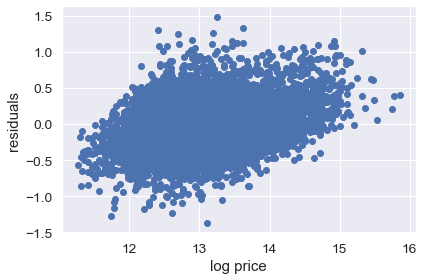

In [137]:
# I dont do a train test split here since this is a simple prediction
df['pricepersqft'] = df['price']/df['sqft_living']

df['pricepersqft_mean'] = df.groupby(['zipcode'])['pricepersqft'].transform('mean') 

testpred = df['pricepersqft_mean']*df['sqft_living']
benchmark_2 = [(np.abs(((np.log1p(testpred)-np.log1p(df['price']))/np.log1p(df['price'])))).mean(),
               ((np.log1p(testpred)-np.log1p(df['price']))/np.log1p(df['price'])).std(),
               np.sqrt(((np.log1p(testpred)-np.log1p(df['price']))**2).sum()/len(df['price']))]
print('The rmse error in log predictions is',round(benchmark_2[2],3))

plt.plot(np.log1p(df['price']),np.log1p(df['price'])-np.log1p(testpred),'bo');
plt.xlabel('log price')
plt.ylabel('residuals')
plt.tight_layout()
plt.savefig('residuals_benchmark_2.png')

### Benchmark 2 is the one to beat. Lets see if we can make sequential improvements to our predictions to improve the result

## Log transform target and skewed features to get better distrubutions. I will use Ridge regression throughout

Index(['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above',
       'bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'sqft_lot15',
       'yr_renovated', 'yr_built', 'condition'],
      dtype='object')
The rmse error in log predictions is 0.3177264000563125


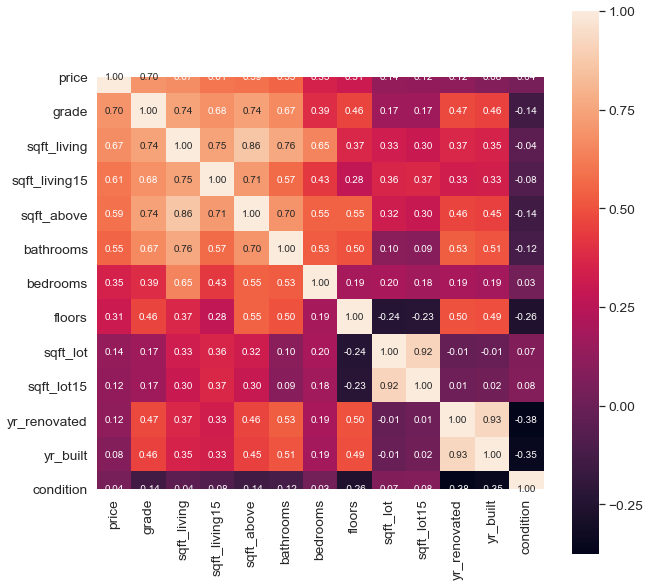

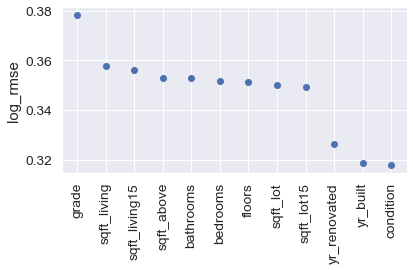

In [147]:
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15']
df_log = fix_skewed(df,lin_feats)

## Lets see the cormat again. It chages a little bit
print(plot_corr(df_log))

# The improvement after taking a log transformation is only a modest one
y = df_log['price']
X = df_log.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

ridge = RidgeCV(alphas=np.logspace(-2,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
#print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The rmse error in log predictions is',log_err[2])

el = []
for x in range(1,df_log.shape[1]):
    e,l,ae = withnfeatures(df_log,x)
    el.append(e)
labels = withnfeatures(df_log,x)[1]
#print(el)
plt.figure()
plt.plot(range(1,df_log.shape[1]),el,'bo')
plt.xticks(range(1,df_log.shape[1]), labels, rotation='vertical')
plt.ylabel('log_rmse')
plt.tight_layout()
plt.savefig('with_log_tranform.png')

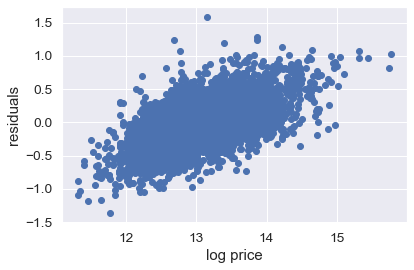

In [148]:
plt.plot(y_test,y_test-testpred,'bo');
plt.xlabel('log price')
plt.ylabel('residuals')
plt.tight_layout()
plt.savefig('residuals_with_log.png')

### We will try two different methods with zipcode. First we will convert zipcode categorical data to numerical. The cattonum function orders the data in ascending order by zipcode and assigns an integer value to build a monotonic relationship

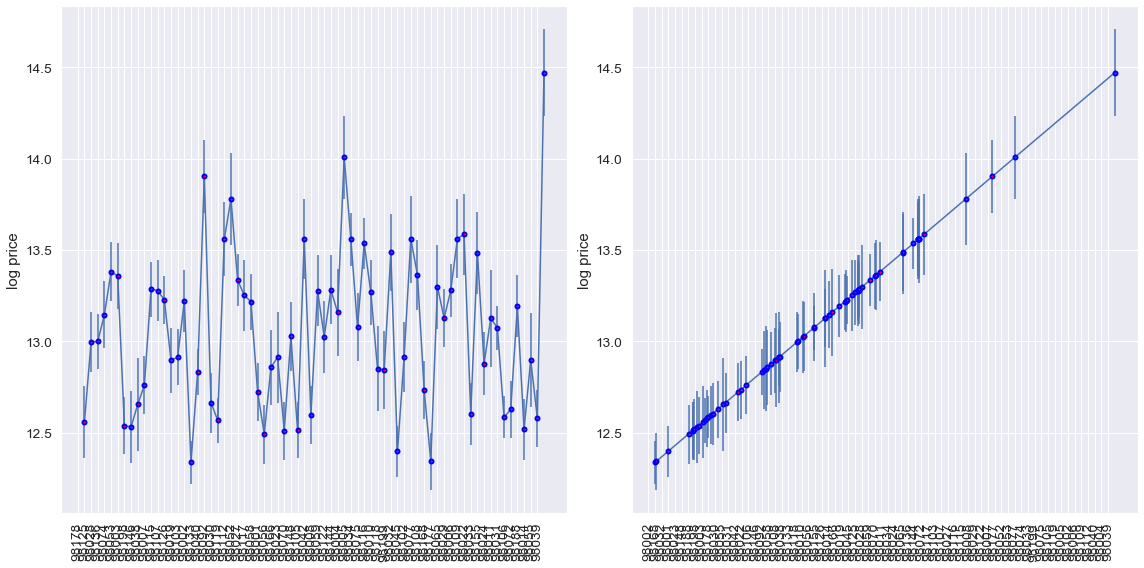

In [159]:
df_zipc_lin = cattonum_lin(df,'zipcode','price')

### Now to do linear regression using zipcode as a continuous variabe

In [160]:
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15','zipcode']

df_log = fix_skewed(df_zipc_lin,lin_feats)

y = df_log['price']
X = df_log.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

ridge = RidgeCV(alphas=np.logspace(-2,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
#print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The rmse error in log predictions is',round(log_err[2],3))


The rmse error in log predictions is 0.218


#### We get a huge improvement

## Does getdummies work as well or better for zipcode?

In [161]:
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15','zipcode']

df_dummies = fix_skewed(df,lin_feats)
df_dummies = pd.get_dummies(df_dummies, columns=['zipcode'],drop_first=True)

y = df_dummies['price']
X = df_dummies.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

ridge = RidgeCV(alphas=np.logspace(-3,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
#print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The rmse error in log predictions is',round(log_err[2],3))


The rmse error in log predictions is 0.192


#### One hot encoding does slightly better. Now let's add more features

## Final Model

The rmse error in log predictions is 0.176


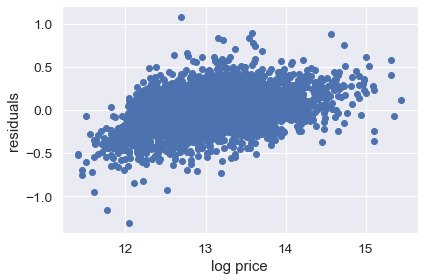

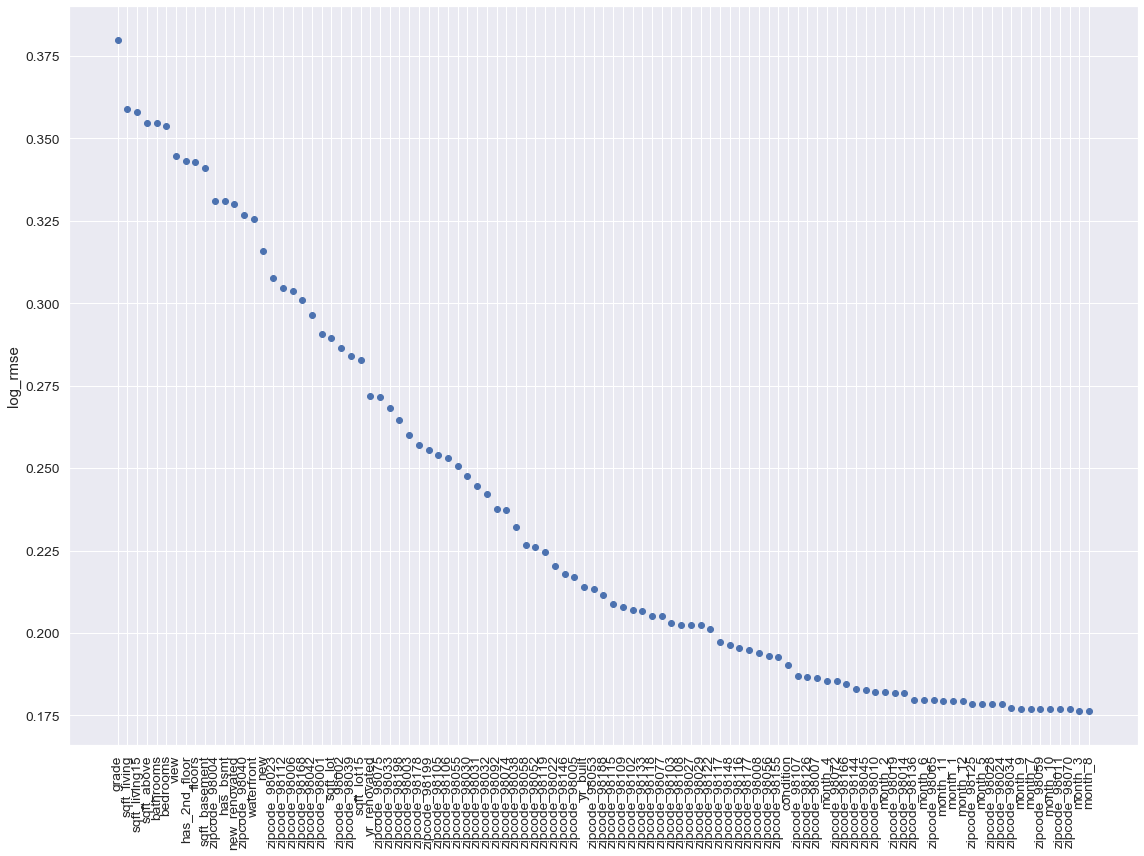

In [168]:
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above','sqft_basement', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15','zipcode','month','has_bsmt','view','waterfront','has_2nd_floor',
             'new_renovated','new']

df_dummies = fix_skewed(df,lin_feats)
df_dummies = pd.get_dummies(df_dummies, columns=['zipcode','month'])

y = df_dummies['price']
X = df_dummies.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

ridge = RidgeCV(alphas=np.logspace(-3,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)

#Preddict on Test data
testpred = ridge.predict(X_test)
#alpha = ridge.alpha_
# print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The rmse error in log predictions is',round(log_err[2],3))
plt.figure()
plt.plot(y_test, y_test-testpred,'bo');
plt.ylabel('residuals')
plt.xlabel('log price')
plt.tight_layout()
plt.savefig('residuals_final_model.png')
#el = []
#for x in range(1,df_dummies.shape[1]):
#    e,l,ae = withnfeatures(df_dummies,x)
#    el.append(e)
#labels = withnfeatures(df_dummies,x)[1]
#print(el)
plt.figure(figsize=(16,12))
plt.plot(range(1,df_dummies.shape[1]),el,'bo');
plt.xticks(range(1,df_dummies.shape[1]), labels, rotation='vertical');
plt.ylabel('log_rmse')
plt.tight_layout()
plt.savefig('final_model.png')

### Our final model has 101 features with a score of 0.176 which is much better than our naive estimate benchmark of 0.249. The features plotted bove have been arranged according to their importance in the corrmat with the target variable price. As can be seen from the plot almost all features contrinute to a drop in log_rmse. The residuals indicate that there is still room for improvement because there is still a dependence of residuals on target price. 

## **Conclusions and Future work on Final model**
####  -**Final score of 0.176 is much better than our benchmark naive predictions**
####  -**Get dummies worked better than converting categorical variables to numerical. However room for improvement there**
####  -**The residuals look better but still a dependence on target variable. Room for improvement**
####  -**Need better feature engineering. Also try alternatives to ridge regression**



# Q2 Can we make recommendations to the seller of the house regarding when to sell it?

#### Typically the sellers of the house only knows the zipcode they are in and maybe the grade of their house. Can we make recommendations regarding when to sell the house based on that information? We will group the data by zipcode and grade and estimate when to sell the house. We define the function below

In [208]:
def predict_time(data,zipc,grade=5,verbose=True):
    ## first groupby and transform to find the mean and std
    ## We will be plotting pricepersqft to get rid of dependence on sqft
    if zipc not in data['zipcode'].unique():
        raise ValueError('Invalid Zipcode')
        return None
    if grade not in data['grade'].unique():
        raise ValueError('Invalid Grade')
        return None
    month = {1:'Jan',2:'Feb',3:'Mar',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
    data['pricepersqft'] = data['price']/data['sqft_living']
    
    gb_zip = df.groupby('zipcode')
    month_mean = ((gb_zip.get_group(zipc)).groupby(['month']).mean())['pricepersqft']
    month_std = ((gb_zip.get_group(zipc)).groupby(['month']).std())['pricepersqft']
    if verbose:
        newfigure = plt.figure(figsize=(20,10))
        ax = newfigure.add_subplot(121)
        ax2 = newfigure.add_subplot(122)

        ax.errorbar(month_mean.index, month_mean, 0.5*month_std, marker='o', mfc='red',
            mec='blue', ms=2, mew=4);
        labels = list(month.values())
        ax.set_title('For your zipcode:%i'% zipc)
        ax.set(ylabel='price/sqft')
        ax.set_xticks(list(month.keys()),labels)
        plt.tight_layout()
    
    if grade in (gb_zip.get_group(zipc))['grade'].unique():
        gb_zip_grade = ((gb_zip.get_group(zipc)).groupby(['grade']))
        month_mean = ((gb_zip_grade.get_group(grade)).groupby(['month']).mean())['pricepersqft']
        month_std = ((gb_zip_grade.get_group(grade)).groupby(['month']).std())['pricepersqft']
        if verbose:
            ax2.errorbar(month_mean.index, month_mean, 0.5*month_std, marker='o', mfc='red',
                 mec='blue', ms=2, mew=4);
            labels = list(month.values())
            ax2.set_title('For your zipcode %i'% zipc + ' and grade %i'  % grade)
            ax2.set(ylabel='price/sqft')
            ax2.set_xticks(list(month.keys()), labels);
            plt.tight_layout()
            plt.savefig('recommendation.png')
    else:
        if verbose:
            print("Not enough data for grade,making predictions on zipcode alone. Try neighboring grade values")
            plt.savefig('recommendation.png')
    worst = np.argmin(month_mean)
    best = np.argmax(month_mean)
    
    if verbose:
        print('Check the plots to verify, plot shows std. deviation for the relevant selections')
        print('The best month to sell your house is', month.get(best))
        print('The worst month to sell your house is', month.get(worst))
    return best,worst 
    

Check the plots to verify, plot shows std. deviation for the relevant selections
The best month to sell your house is Mar
The worst month to sell your house is Dec


(3, 12)

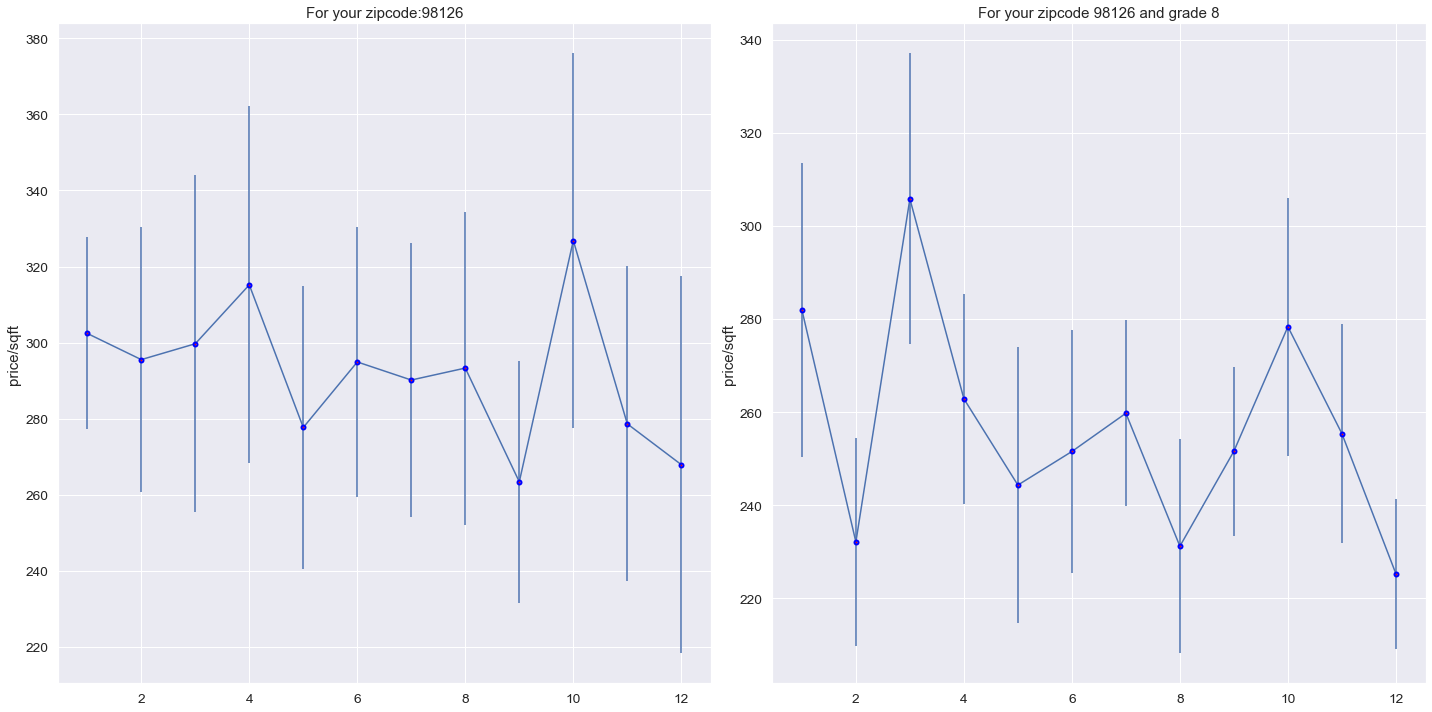

In [209]:
predict_time(df,df['zipcode'].unique()[13],df['grade'].unique()[2],verbose=True)

### Which months are best and worst to sell in aggregate?

In [189]:
best = np.zeros([df.zipcode.nunique(),df.grade.nunique()])
worst = np.zeros([df.zipcode.nunique(),df.grade.nunique()])
for i,zipc in enumerate(np.sort(df.zipcode.unique())):
    for j,grade in enumerate(np.sort(df.grade.unique())):
        best[i,j] = predict_time(df,zipc=zipc,grade=grade,verbose=False)[0]
        worst[i,j] = predict_time(df,zipc=zipc,grade=grade,verbose=False)[1]

In [228]:
print('On average the best month to sell your house is', int(collections.Counter(best.flatten()).most_common(1)[0][0]))

On average the best month to sell your house is 4


In [229]:
print('On average the worst month to sell your house is', int(collections.Counter(worst.flatten()).most_common(1)[0][0]))

On average the worst month to sell your house is 1


### With more data we can do a lot of improvement to the predictor function. An immediate updrade would be to do hyopthesis testing to return a confidence level of selling your house now vs later.

# Q3 Can we  the give the  buyer of the house a list of houses for his needs?

### Typically when buying a new house we would like to know how much it would cost based on our criterion, on an average. The most important criterion can be living within a certain radius of a particular location, typically work. Although this data is historical we can still use it to find out the average range of prices in a certain zicode. Here we write a simple function to do that. The buyer will need to specify the distance from the position he gave

In [230]:
from math import sin, cos, sqrt, atan2, radians
## Calculating distance between  given latitude and longitude
def get_dist(pos1,pos2):
    ## Found the code on stack overflow and modified it
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(pos1[0])
    lon1 = radians(pos1[1])
    lat2 = radians(pos2[0])
    lon2 = radians(pos2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    ## return distance in miles
    return round(distance*(0.6213),1)

In [232]:
# Combining latitude and longitude data
df['lat_long'] = list(zip(df.lat, df.long))

In [256]:
def get_range(pos,dist=10,bedrooms_min=0,bathrooms_min=1,price_min=0, price_max= 10**9,sqft_living_min=0,sqft_lot_min=0,has_bsmt=None,waterfront=None,view=None,df=df):
    df_ans = df.copy()
    #first find distances
    df_ans['distance'] = [get_dist(pos,pos2) for pos2 in df['lat_long']]
    # select based on distances
    df_ans = df_ans[df_ans['distance'] < dist]
    
    #select based on other features
    df_ans = df_ans[df_ans['bedrooms'] >= bedrooms_min]
    df_ans = df_ans[df_ans['bathrooms'] >= bathrooms_min]

    df_ans = df_ans[(price_min <= df_ans['price']) & (df_ans['price']<= price_max)]
    df_ans = df_ans[df_ans['sqft_living'] >= sqft_living_min]
    df_ans = df_ans[df_ans['sqft_lot'] >= sqft_lot_min]
    
    if has_bsmt !=None:
        df_ans = df_ans[df_ans['has_bsmt']==has_bsmt]
    if waterfront !=None:
        df_ans = df_ans[df_ans['waterfront']==waterfront]
    if view !=None:
        df_ans = df_ans[df_ans['view'] == view]
        
    if(len(df_ans)==0):
        print('No matches found for your selection. Try alternate criterion')
    else:
        dat = round(df_ans.groupby('zipcode').mean()['price'])
        print('The zipcode and expected average price of your selection')
        print(pd.DataFrame(dat.sort_values()))
    return df_ans[['zipcode','sqft_living','bedrooms','bathrooms','price']].sort_values('price')

#### As an example if I want 2 bedrooms 1 bathroom within 3 miles of my location, and I am willing to pay a maximum price of 3,00,000 dollars and want a minimum 1200 sqft for living and lot. The function will print out the zipcodes and the associated average prices of your selection. it will also return a dataframe with features of interest sorted by price

In [260]:
ans = get_range(df['lat_long'].iloc[0],3,bedrooms_min=2,bathrooms_min=1,price_max=3*10**5,sqft_living_min=1200,sqft_lot_min=1200)

The zipcode and expected average price of your selection
            price
zipcode          
98055    228595.0
98168    236623.0
98178    245812.0
98118    246289.0
98188    262000.0
98056    267500.0
98108    275489.0


In [261]:
ans

,sqft_living,bedrooms,bathrooms,price
15796,1430,5,2.00,133000.0
13215,1460,4,2.00,150000.0
2181,1450,3,1.00,150000.0
15048,1200,3,1.00,150000.0
5720,1470,4,1.00,150550.0
...,...,...,...,...
16878,1340,2,1.00,300000.0
15594,1350,3,1.75,300000.0
15885,1700,3,2.50,300000.0
19579,2000,3,2.25,300000.0


#### Of course this function is much more useful with live data. We can build a visualization by plotting the houses and their attributes on a map

# END OF NOTEBOOK